In [1]:
# Ensure off-screen rendering for VTK/pyvista and set Matplotlib to Agg for headless-safe plotting
import os, sys
# Set before imports of pyvista/vtk
os.environ.setdefault('PYVISTA_OFF_SCREEN', '1')
# Set Matplotlib backend for headless rendering
os.environ.setdefault('MPLBACKEND', 'Agg')
# Warn if pyvista/vtk already imported
_imported = [m for m in ('pyvista', 'vtk') if m in sys.modules]
if _imported:
    print('WARNING: the following modules are already imported:', _imported)
    print('To ensure off-screen rendering takes effect, restart the kernel and re-run this cell before importing pyvista/vtk')
else:
    print('PYVISTA_OFF_SCREEN set to', os.environ.get('PYVISTA_OFF_SCREEN'))
    print('MPLBACKEND set to', os.environ.get('MPLBACKEND'))


PYVISTA_OFF_SCREEN set to 1
MPLBACKEND set to module://matplotlib_inline.backend_inline


In [2]:
# standard numpy and matplotlib library imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import linregress, levene, mannwhitneyu
import matplotlib.ticker as ticker
import tifffile
from skimage import measure
import pyvista as pv
import os



In [3]:
# import brain volume csv file

# Replace 'your_file.csv' with the path to your file
all_volumes = pd.read_csv('data/brainvolume/refbrain_brainvolumedata.csv')

# split up dataframes based on experiment column

refbrain_df = all_volumes[all_volumes['Experiment'] == 'refbrain']

lineA_df = all_volumes[all_volumes['Experiment'] == 'lineA']

intercastevworker_df = all_volumes[all_volumes['Experiment'] == 'intercastevworker']

brainvbody_df = all_volumes[all_volumes['Experiment'] == 'brainvbody']

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


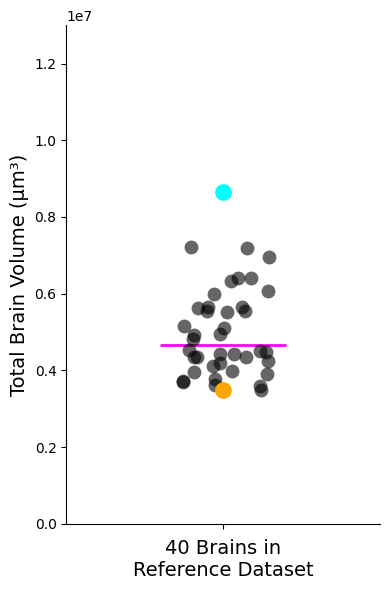

In [4]:
# Generating Fig2A -- brain volumes in reference brain 

# Filter rows where 'Condition' is 'included' to only plot the 40 brains in the volume
filtered_df = refbrain_df[refbrain_df['Condition'] == 'included']

plt.figure(figsize=(4, 6))

# Overlay individual data points (scatter plot)
sns.stripplot(x=[0] * len(filtered_df), y=filtered_df['AMIRA volume'], color='black', jitter=0.15, size=10, alpha=0.6)

# Set y-axis limits
plt.ylim(0, 1.3e7)

# Calculate median
refbrain_median = filtered_df['AMIRA volume'].median()

min_idx = filtered_df['AMIRA volume'].idxmin()
max_idx = filtered_df['AMIRA volume'].idxmax()

# Plot median as a red line
plt.hlines(y=refbrain_median, xmin=-0.2, xmax=0.2, colors='magenta', linewidth=2)  # Narrow line to match category width

# Plot the min value as an open red circle
plt.scatter(x=0, 
            y=filtered_df.loc[min_idx, 'AMIRA volume'], 
            facecolors='orange', edgecolors='orange', alpha=1, linewidth=2, s=100, zorder=10)

# Plot the max value as an open blue circle
plt.scatter(x=0, 
            y=filtered_df.loc[max_idx, 'AMIRA volume'], 
            facecolors='cyan', edgecolors='cyan', alpha=1, linewidth=2, s=100, zorder=10)

# Set x-axis limits to keep the spread similar to a single category in a dual-category plot
plt.xlim(-0.5, 0.5)

# Keep the tick mark at 0 but remove its numeric label
plt.xticks([0], [''], fontsize=14)

# Keep only x and y axis 
sns.despine(top=True, right=True)

# Axis labels# Labels and title
plt.xlabel("40 Brains in\nReference Dataset", fontsize=14)
plt.ylabel("Total Brain Volume (μm³)", fontsize=14)


# Tighten the layout to avoid any clipping
plt.tight_layout()

# Save the plot as an EPS and PNG file
plt.savefig("figures/Fig2A_indvbrainvolumesinrefbrain.eps", format='eps', dpi=300)
plt.savefig("figures/Fig2A_indvbrainvolumesinrefbrain.png", format='png', dpi=600)

# Show the plot
plt.show()

In [5]:
# Generating Fig 2B -- 3D brain renderings of largest and smallest brain

# import 3D brain meshes (as tifs) generated in AMIRA
largest_brain_file = 'synA647_LL_4_220214_resampled_0.8x0.8x0.processed0_manualfix.tif'
smallest_brain_file = 'synA647_LL_201213_263_resampled_0.8x0.8x0.processed0_manualfix.tif'
mesh_path = 'data/brainvolume/brain_meshes/'


In [6]:
# Start with largest brain

# Load label image
largest_brain = tifffile.imread(os.path.join(mesh_path, largest_brain_file))

# Step 2: Extract one label (e.g., label = 1)
label_id = 1
binary_mask = (largest_brain == label_id)

# Guard: ensure mask contains something
if not np.any(binary_mask):
    print(f'No label {label_id} found in {largest_brain_file} -- skipping render')
else:
    try:
        # marching_cubes can be sensitive to dtypes; use a numeric array
        verts, faces, normals, values = measure.marching_cubes(binary_mask.astype(np.uint8), level=0)
    except Exception as e:
        print(f'ERROR: marching_cubes failed for {largest_brain_file}: {e}')
        verts = faces = None
    if verts is None or faces is None or len(faces) == 0:
        print(f'No mesh extracted for {largest_brain_file} -- skipping render')
    else:
        # PyVista expects faces as a flat int array: [3, i0, i1, i2, 3, j0, j1, j2, ...]
        faces = np.asarray(faces, dtype=np.int64)
        faces_flat = np.hstack([[3, f[0], f[1], f[2]] for f in faces])
        try:
            mesh = pv.PolyData(verts, faces_flat)
        except Exception as e:
            print(f'ERROR creating PolyData for {largest_brain_file}: {e}')
            mesh = None
        if mesh is None:
            print('Skipping rendering due to mesh creation error')
        else:
            # Try a simplified mesh for smoothing (guarded)
            try:
                simplified_mesh = mesh.decimate_pro(0.2) if hasattr(mesh, 'decimate_pro') else mesh
            except Exception as e:
                print(f'WARNING: decimation failed: {e}; continuing with original mesh')
                simplified_mesh = mesh
            try:
                # Use the standard smooth signature; some pyvista versions don't accept relaxation_factor
                smoothed_mesh = simplified_mesh.smooth(n_iter=300) if hasattr(simplified_mesh, 'smooth') else simplified_mesh
            except Exception as e:
                print(f'WARNING: smoothing failed: {e}; continuing with simplified mesh')
                smoothed_mesh = simplified_mesh
            # Step 5: Set up off-screen plotter and save screenshot instead of interactive show
            pv.OFF_SCREEN = True
            plotter = pv.Plotter(off_screen=True)
            plotter.add_mesh(smoothed_mesh, color="cyan", smooth_shading=True)
            plotter.set_background("white")
            # Make appropriate scale bar
            voxel_size = 0.8  # microns per voxel
            scale_bar_length_voxels = 50 / voxel_size
            bounds = smoothed_mesh.bounds
            start = [bounds[0], bounds[2], bounds[4]]  # xmin, ymin, zmin
            end = [bounds[0], bounds[2], bounds[4] + scale_bar_length_voxels]  # along Z axis
            scale_bar = pv.Line(start, end)
            plotter.add_mesh(scale_bar, color='black', line_width=5)
            # Adjust camera
            plotter.view_vector((-1, 0, 0), viewup=(0, -1, 0))
            # Save screenshot instead of opening interactive window
            plotter.screenshot("figures/Fig2B_largestbrain_withscale.png", window_size=(1920, 1080))
            plotter.close()


In [7]:
# Now do the smallest brain

# Load label image
smallest_brain = tifffile.imread(os.path.join(mesh_path, smallest_brain_file))

# Step 2: Extract one label (e.g., label = 1)
label_id = 1
binary_mask = (smallest_brain == label_id)

if not np.any(binary_mask):
    print(f'No label {label_id} found in {smallest_brain_file} -- skipping render')
else:
    try:
        verts, faces, normals, values = measure.marching_cubes(binary_mask.astype(np.uint8), level=0)
    except Exception as e:
        print(f'ERROR: marching_cubes failed for {smallest_brain_file}: {e}')
        verts = faces = None
    if verts is None or faces is None or len(faces) == 0:
        print(f'No mesh extracted for {smallest_brain_file} -- skipping render')
    else:
        faces = np.asarray(faces, dtype=np.int64)
        faces_flat = np.hstack([[3, f[0], f[1], f[2]] for f in faces])
        try:
            mesh = pv.PolyData(verts, faces_flat)
        except Exception as e:
            print(f'ERROR creating PolyData for {smallest_brain_file}: {e}')
            mesh = None
        if mesh is None:
            print('Skipping rendering due to mesh creation error')
        else:
            try:
                simplified_mesh = mesh.decimate_pro(0.2) if hasattr(mesh, 'decimate_pro') else mesh
            except Exception as e:
                print(f'WARNING: decimation failed: {e}; continuing with original mesh')
                simplified_mesh = mesh
            try:
                smoothed_mesh = simplified_mesh.smooth(n_iter=300) if hasattr(simplified_mesh, 'smooth') else simplified_mesh
            except Exception as e:
                print(f'WARNING: smoothing failed: {e}; continuing with simplified mesh')
                smoothed_mesh = simplified_mesh
            pv.OFF_SCREEN = True
            plotter = pv.Plotter(off_screen=True)
            plotter.add_mesh(smoothed_mesh, color="orange", smooth_shading=True)
            plotter.set_background("white")
            voxel_size = 0.8  # microns per voxel
            scale_bar_length_voxels = 50 / voxel_size
            bounds = smoothed_mesh.bounds
            start = [bounds[0], bounds[2], bounds[4]]  # xmin, ymin, zmin
            end = [bounds[0], bounds[2], bounds[4] + scale_bar_length_voxels]  # along Z axis
            scale_bar = pv.Line(start, end)
            plotter.add_mesh(scale_bar, color='black', line_width=5)
            plotter.view_vector((-1, 0, 0), viewup=(0, -1, 0))
            plotter.screenshot("figures/Fig2Bsmallestbrain_withscale.png", window_size=(1920, 1080))
            plotter.close()


/var/folders/_3/s49npsyn10dc_56t6wsj395h0000gn/T/ipykernel_65622/1617584064.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  refbrain_df['Avg AL'] = (refbrain_df['R AL'] + refbrain_df['L AL'])/ 2
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


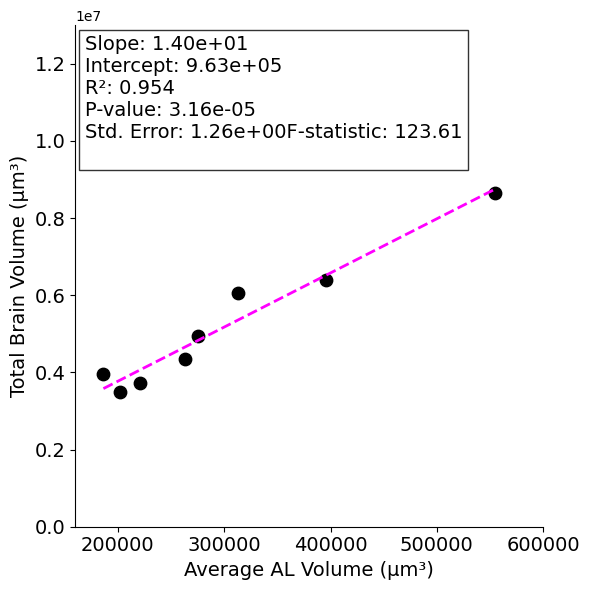

In [8]:
# Generating Fig2C -- brain volumes vs AL volume

# Calculate average AL volume for each brain
refbrain_df['Avg AL'] = (refbrain_df['R AL'] + refbrain_df['L AL'])/ 2

# set up dataframes correctly
refbrain_df_noavg = refbrain_df[refbrain_df['Condition'] != 'averaged']
refbrain_df_noavg = refbrain_df_noavg[refbrain_df_noavg['Condition'] != 'excluded']
refbrain_df_npseg = refbrain_df_noavg.dropna(subset=['Avg AL', 'AMIRA volume'])

# Make figure 
plt.figure(figsize=(6, 6))

# Scatter plot for continuous body length on the x-axis and total brain volume on the y-axis
plt.scatter(refbrain_df_npseg['Avg AL'], refbrain_df_npseg['AMIRA volume'], alpha=1, color='black', s=80)

# Fit a linear regression line
slope, intercept, r_value, p_value, std_err = linregress(refbrain_df_npseg['Avg AL'], refbrain_df_npseg['AMIRA volume'])

# Generate regression line
x_vals = np.linspace(refbrain_df_npseg['Avg AL'].min(), refbrain_df_npseg['Avg AL'].max(), 100)
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, color='magenta', linewidth=2, linestyle='--')

# Calculate F-statistic
n = len(refbrain_df_npseg)
r_squared = r_value ** 2
f_statistic = (r_squared / (1 - r_squared)) * (n - 2)

# Regression statistics text (formatted nicely)
regression_text = (
    f"Slope: {slope:.2e}\n"
    f"Intercept: {intercept:.2e}\n"
    f"R²: {r_value**2:.3f}\n"
    f"P-value: {p_value:.2e}\n"
    f"Std. Error: {std_err:.2e}"
    f"F-statistic: {f_statistic:.2f}\n"
)

# Add text to top-right corner of the plot
plt.text(
    0.02, 0.98, regression_text, transform=plt.gca().transAxes, 
    fontsize=14, verticalalignment='top', horizontalalignment='left',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='black')
)

# Set y-axis limits (total brain volume)
plt.ylim(0, 1.3e7)

# Set tick positions
tick_vals = np.arange(2e5, 7e5, 1e5)  

# Set x-axis limits
plt.xlim(1.6e5, 6.0e5)

# Set tick locations
plt.xticks(tick_vals)

# Labels and title
plt.xlabel("Average AL Volume (μm³)", fontsize=14)
plt.ylabel("Total Brain Volume (μm³)", fontsize=14)

# Change font sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Keep only x and y axis 
sns.despine(top=True, right=True)

# Adjust layout to avoid clipping of labels
plt.tight_layout()

# Save the plot as an EPS and PNGfile
plt.savefig("figures/Fig2C_brainvolumevsALvolume.eps", format='eps', dpi=300)
plt.savefig("figures/Fig2C_brainvolumevsALvolume.png", format='png', dpi=600)

plt.show()


/var/folders/_3/s49npsyn10dc_56t6wsj395h0000gn/T/ipykernel_65622/880468268.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  refbrain_df_subset['avg MB'] = (refbrain_df_subset['R MB'] + refbrain_df['L MB'])/ 2
/var/folders/_3/s49npsyn10dc_56t6wsj395h0000gn/T/ipykernel_65622/880468268.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  refbrain_df_subset['avg MB'] = (refbrain_df_subset['R MB'] + refbrain_df['L MB'])/ 2
The PostScript backend does not support transparency; partially transparent artists wil

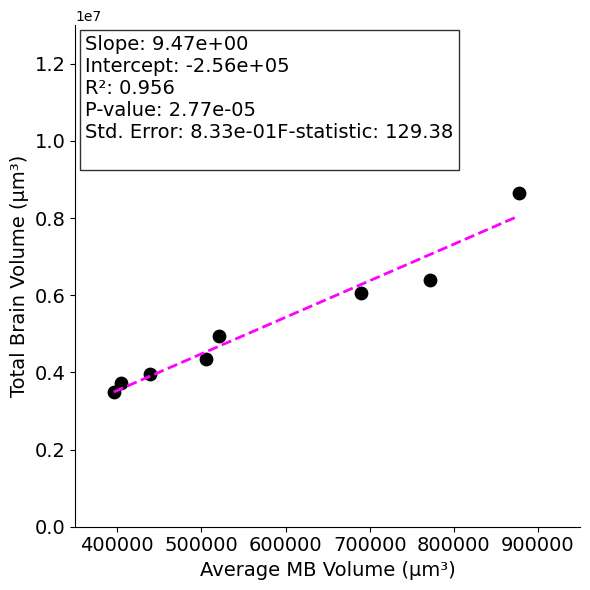

In [9]:
# Generating Fig2D -- total brain volume vs MB volume

# Keep only rows where at least one AL is annotated
refbrain_df_subset = refbrain_df.dropna(subset=['R AL', 'L AL'], how='all')

# Calculate average MB for each brain
refbrain_df_subset['avg MB'] = (refbrain_df_subset['R MB'] + refbrain_df['L MB'])/ 2

# Calculate average MB for each brain
refbrain_df_subset['avg MB'] = (refbrain_df_subset['R MB'] + refbrain_df['L MB'])/ 2

# set up dataframes correctly
refbrain_df_noavg = refbrain_df_subset[refbrain_df_subset['Condition'] != 'averaged']
refbrain_df_noavg = refbrain_df_noavg[refbrain_df_noavg['Condition'] != 'excluded']
refbrain_df_npseg = refbrain_df_noavg.dropna(subset=['avg MB', 'AMIRA volume'])

# Generate Figure
plt.figure(figsize=(6, 6))

# Scatter plot for continuous body length on the x-axis and total brain volume on the y-axis
plt.scatter(refbrain_df_npseg['avg MB'], refbrain_df_npseg['AMIRA volume'], alpha=1, color='black', s=80)

# Fit a linear regression line
slope, intercept, r_value, p_value, std_err = linregress(refbrain_df_npseg['avg MB'], refbrain_df_npseg['AMIRA volume'])

# Generate regression line
x_vals = np.linspace(refbrain_df_npseg['avg MB'].min(), refbrain_df_npseg['avg MB'].max(), 100)
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, color='magenta', linewidth=2, linestyle='--')

# Calculate F-statistic
n = len(refbrain_df_npseg)
r_squared = r_value ** 2
f_statistic = (r_squared / (1 - r_squared)) * (n - 2)

# Regression statistics text (formatted nicely)
regression_text = (
    f"Slope: {slope:.2e}\n"
    f"Intercept: {intercept:.2e}\n"
    f"R²: {r_value**2:.3f}\n"
    f"P-value: {p_value:.2e}\n"
    f"Std. Error: {std_err:.2e}"
    f"F-statistic: {f_statistic:.2f}\n"
)

#Add text to top-right corner of the plot
plt.text(
    0.02, 0.98, regression_text, transform=plt.gca().transAxes, 
    fontsize=14, verticalalignment='top', horizontalalignment='left',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='black')
)

# Set y-axis limits (total brain volume)
plt.ylim(0, 1.3e7)

# Set tick positions
tick_vals = np.arange(4e5, 9.1e5, 1e5)  # 4e5 to 10e5 inclusive

# Set x-axis limits
plt.xlim(3.5e5, 9.5e5)

# Set tick locations
plt.xticks(tick_vals)

# Labels and title
plt.xlabel("Average MB Volume (μm³)", fontsize=14)
plt.ylabel("Total Brain Volume (μm³)", fontsize=14)

# Change font sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Keep only x and y axis 
sns.despine(top=True, right=True)

# Adjust layout to avoid clipping of labels
plt.tight_layout()

# Save the plot as an EPS and PNGfile
plt.savefig("figures/Fig2D_brainvolumevsMBvolume.eps", format='eps', dpi=300)
plt.savefig("figures/Fig2D_brainvolumevsMBvolume.png", format='png', dpi=600)

plt.show()

/var/folders/_3/s49npsyn10dc_56t6wsj395h0000gn/T/ipykernel_65622/2207818261.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  refbrain_df['avg OL'] = (refbrain_df['R OL'] + refbrain_df['L OL'])/ 2
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


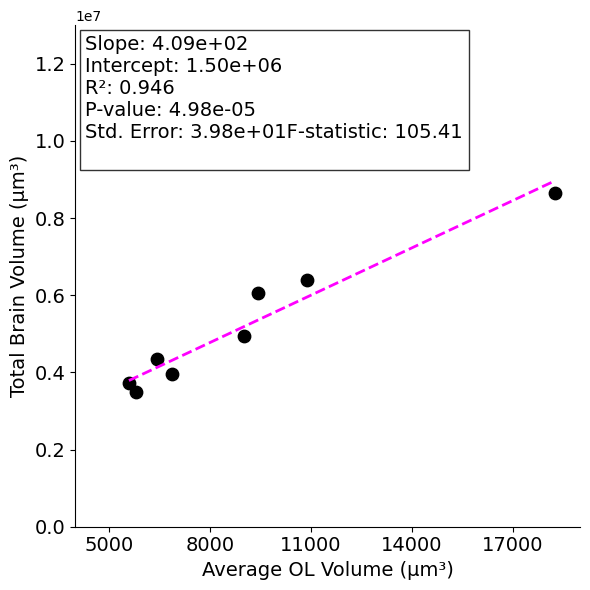

In [10]:
# Generating Fig2E -- total brain volume vs OL volume

# Calculate average OL for each brain
refbrain_df['avg OL'] = (refbrain_df['R OL'] + refbrain_df['L OL'])/ 2

# set up dataframes correctly
refbrain_df_noavg = refbrain_df[refbrain_df['Condition'] != 'averaged']
refbrain_df_noavg = refbrain_df_noavg[refbrain_df_noavg['Condition'] != 'excluded']
refbrain_df_npseg = refbrain_df_noavg.dropna(subset=['avg OL', 'AMIRA volume'])

# Generate figure
plt.figure(figsize=(6, 6))

# Scatter plot for continuous body length on the x-axis and total brain volume on the y-axis
plt.scatter(refbrain_df_npseg['avg OL'], refbrain_df_npseg['AMIRA volume'], alpha=1, color='black', s=80)

# Fit a linear regression line
slope, intercept, r_value, p_value, std_err = linregress(refbrain_df_npseg['avg OL'], refbrain_df_npseg['AMIRA volume'])

# Generate regression line
x_vals = np.linspace(refbrain_df_npseg['avg OL'].min(), refbrain_df_npseg['avg OL'].max(), 100)
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, color='magenta', linewidth=2, linestyle='--')

# Calculate F-statistic
n = len(refbrain_df_npseg)
r_squared = r_value ** 2
f_statistic = (r_squared / (1 - r_squared)) * (n - 2)

# Regression statistics text (formatted nicely)
regression_text = (
    f"Slope: {slope:.2e}\n"
    f"Intercept: {intercept:.2e}\n"
    f"R²: {r_value**2:.3f}\n"
    f"P-value: {p_value:.2e}\n"
    f"Std. Error: {std_err:.2e}"
    f"F-statistic: {f_statistic:.2f}\n"
)

# Add text to top-right corner of the plot
plt.text(
    0.02, 0.98, regression_text, transform=plt.gca().transAxes, 
    fontsize=14, verticalalignment='top', horizontalalignment='left',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='black')
)

# Set y-axis limits (total brain volume)
plt.ylim(0, 1.3e7)

# Set tick positions
tick_vals = np.arange(5e3, 19e3, 3e3)  

# Set x-axis limits
plt.xlim(4e3, 19e3)

# Set tick locations
plt.xticks(tick_vals)

# Labels and title
plt.xlabel("Average OL Volume (μm³)", fontsize=14)
plt.ylabel("Total Brain Volume (μm³)", fontsize=14)

# Change font sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Keep only x and y axis 
sns.despine(top=True, right=True)

# Adjust layout to avoid clipping of labels
plt.tight_layout()

# Save the plot as an EPS and PNGfile
plt.savefig("figures/Fig2E_brainvolumevsOLvolume.eps", format='eps', dpi=300)
plt.savefig("figures/Fig2E_brainvolumevsOLvolume.png", format='png', dpi=600)

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


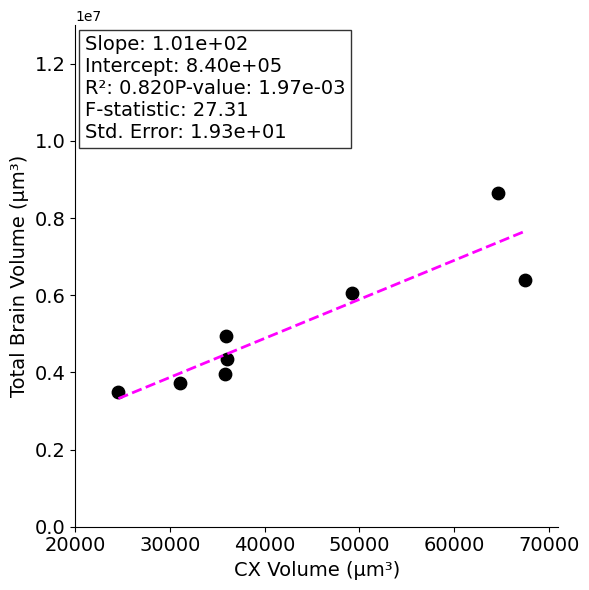

In [11]:
# Generating Fig2F -- total brain volume vs CX volume

# set up dataframes correctly
refbrain_df_noavg = refbrain_df[refbrain_df['Condition'] != 'averaged']
refbrain_df_noavg = refbrain_df_noavg[refbrain_df_noavg['Condition'] != 'excluded']
refbrain_df_npseg = refbrain_df_noavg.dropna(subset=['CX', 'AMIRA volume'])


# Generate figure
plt.figure(figsize=(6, 6))

# Scatter plot for continuous body length on the x-axis and total brain volume on the y-axis
plt.scatter(refbrain_df_npseg['CX'], refbrain_df_npseg['AMIRA volume'], alpha=1, color='black', s=80)

# Fit a linear regression line
slope, intercept, r_value, p_value, std_err = linregress(refbrain_df_npseg['CX'], refbrain_df_npseg['AMIRA volume'])

# Generate regression line
x_vals = np.linspace(refbrain_df_npseg['CX'].min(), refbrain_df_npseg['CX'].max(), 100)
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, color='magenta', linewidth=2, linestyle='--')

# Calculate F-statistic
n = len(refbrain_df_npseg)
r_squared = r_value ** 2
f_statistic = (r_squared / (1 - r_squared)) * (n - 2)

# Regression statistics text (formatted nicely)
regression_text = (
    f"Slope: {slope:.2e}\n"
    f"Intercept: {intercept:.2e}\n"
    f"R²: {r_value**2:.3f}" #"\n"
    f"P-value: {p_value:.2e}\n"
    f"F-statistic: {f_statistic:.2f}\n"
    f"Std. Error: {std_err:.2e}"
)

# Add text to top-right corner of the plot
plt.text(
    0.02, 0.98, regression_text, transform=plt.gca().transAxes, 
    fontsize=14, verticalalignment='top', horizontalalignment='left',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='black')
)

# Set y-axis limits (total brain volume)
plt.ylim(0, 1.3e7)

# Set tick positions
tick_vals = np.arange(2e4, 7e4, 1e4)  

# Set x-axis limits
plt.xlim(2e4, 7.1e4)

# Set y-axis limits (total brain volume)
plt.ylim(0, 1.3e7)


# Labels and title
plt.xlabel("CX Volume (μm³)", fontsize=14)
plt.ylabel("Total Brain Volume (μm³)", fontsize=14)

# Change font sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Keep only x and y axis 
sns.despine(top=True, right=True)

# Adjust layout to avoid clipping of labels
plt.tight_layout()

# Save the plot as an EPS file
plt.savefig("figures/Fig2F_brainvolumevsCXvolume.eps", format='eps', dpi=300)
plt.savefig("figures/Fig2F_brainvolumevsCXvolume.png", format='png', dpi=600)

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


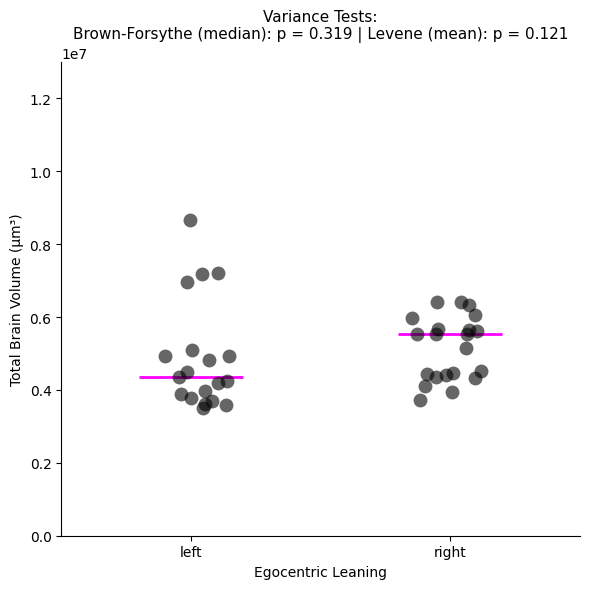

In [12]:
# Generating Supp Fig 2A -- left vs right leaning brain volume comparison

# Filter rows where 'Condition' is 'included'
filtered_df = refbrain_df[refbrain_df['Condition'] == 'included']

# Split AMIRA volume by group
left_volumes = filtered_df[filtered_df['Egocentric Leaning'] == 'left']['AMIRA volume']
right_volumes = filtered_df[filtered_df['Egocentric Leaning'] == 'right']['AMIRA volume']

# Run Brown-Forsythe test (median-centered)
bf_stat, bf_p = levene(left_volumes, right_volumes, center='median')

# Run Levene’s test (mean-centered)
lev_stat, lev_p = levene(left_volumes, right_volumes, center='mean')

# Mann-Whitney U test (tests for difference in medians/distributions)
mw_stat, mw_p = mannwhitneyu(left_volumes, right_volumes, alternative='two-sided')

# Generate plot
plt.figure(figsize=(6, 6))

# Plot individual data points by Egocentric Leaning (left vs right)
sns.stripplot(
    x='Egocentric Leaning',
    y='AMIRA volume',
    data=filtered_df,
    order=['left', 'right'],
    jitter=0.15,
    size=10,
    alpha=0.6,
    color='black'
)

# Set y-axis limits
plt.ylim(0, 1.3e7)
plt.xlim(-0.5, 1.5)

# Axis labels
plt.xlabel("Egocentric Leaning")
plt.ylabel("Total Brain Volume (μm³)")


# Plot median lines per group
medians = filtered_df.groupby('Egocentric Leaning')['AMIRA volume'].median()
plt.hlines(
    y=medians.values,
    xmin=[-0.2, 0.8],
    xmax=[0.2, 1.2],
    colors='magenta',
    linewidth=2
)

# Annotate p-values in the title
plt.title(
    f"Variance Tests:\n"
    f"Brown-Forsythe (median): p = {bf_p:.3g} | "
    f"Levene (mean): p = {lev_p:.3g}",
    fontsize=11
)

# Keep only x and y axis 
sns.despine(top=True, right=True)

plt.tight_layout()

# Save the plot as an EPS and PNGfile
plt.savefig("figures/SF2A_egocentricleaning_vs_volume.eps", format='eps', dpi=300)
plt.savefig("figures/SF2A_egocentricleaning_vs_volume.png", format='png', dpi=600)

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


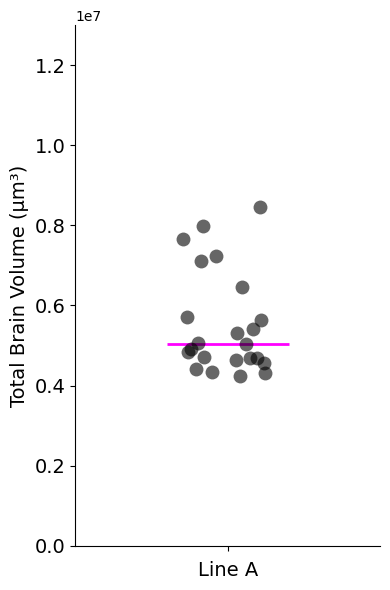

In [13]:
# Generating Supp Fig 2B -- line A brain volumes

plt.figure(figsize=(4, 6))

# Overlay individual data points (scatter plot)
sns.stripplot(x=[0] * len(lineA_df), y=lineA_df['AMIRA volume'], color='black', jitter=0.15, size=10, alpha=0.6)

# Set y-axis limits
plt.ylim(0, 1.3e7)

# Labels and title
plt.xlabel("Line A", fontsize=14)  
plt.ylabel("Total Brain Volume (μm³)", fontsize=14)

# Calculate median
lineA_median = lineA_df['AMIRA volume'].median()

# Plot median as a red line
plt.hlines(y=lineA_median, xmin=-0.2, xmax=0.2, colors='magenta', linewidth=2)  # Narrow line to match category width

# Set x-axis limits to keep the spread similar to a single category in a dual-category plot
plt.xlim(-0.5, 0.5)

# Change font sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Keep only x and y axis 
sns.despine(top=True, right=True)

# Get rid of x tick label
plt.xticks([0], [''])

# Tighten the layout to avoid any clipping
plt.tight_layout()

# Save the plot as an EPS and PNGfile
plt.savefig("figures/SF2B_lineA_volume.eps", format='eps', dpi=300)
plt.savefig("figures/SF2B_lineA_volume.png", format='png', dpi=600)

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


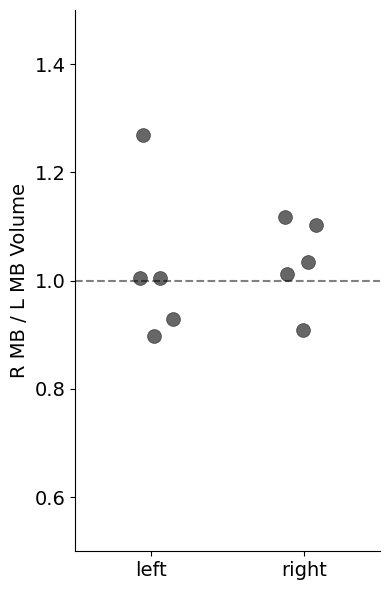

Mann–Whitney U test:
U statistic = 8.000
p-value = 0.4206


In [14]:
# Generating Figure 1M -- does egocentric leaning impact MB volume ratio

# Filter rows where 'Condition' is 'included'
refbrain_df_noavg = refbrain_df[refbrain_df['Condition'] == 'included']

# Pivot to wide format to calculate R/L ratio
pivot_df = refbrain_df_noavg.pivot(index='Clean Name', columns='Condition', values=['R MB', 'L MB'])
pivot_df.columns = ['R MB', 'L MB']
pivot_df = pivot_df.dropna()  # Drop rows where either R or L is missing

# Merge with metadata (like Egocentric Leaning)
meta = refbrain_df_noavg[['Clean Name', 'Egocentric Leaning']].drop_duplicates()
ratio_df = pivot_df.merge(meta, left_index=True, right_on='Clean Name')

# Calculate ratio
ratio_df['R_to_L'] = ratio_df['R MB'] / ratio_df['L MB']

# Plotting
plt.figure(figsize=(4, 6))

leaning_palette = {'left': sns.color_palette('Set2')[0], 'right': sns.color_palette('Set2')[1]}
sns.stripplot(data=ratio_df, y='R_to_L', x='Egocentric Leaning',
              color='black', jitter=0.15, alpha=0.6, size=10, edgecolor='black', linewidth=0.5)

# Add a horizontal line at 1 (equal volume)
plt.axhline(1, color='gray', linestyle='--')

# Styling
plt.ylim(.5, 1.5)
plt.xlim(-0.5, 1.5)
plt.yticks([.6, .8, 1, 1.2, 1.4])

# Axis with labels
plt.ylabel("R MB / L MB Volume", fontsize=14)
plt.xlabel("", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Keep only x and y axis 
sns.despine(top=True, right=True)

# Tighten the layout to avoid any clipping
plt.tight_layout()

# Save and show
plt.savefig("figures/Fig1M_MBvolume_leftvsright.png", format='png', dpi=600)
plt.savefig("figures/Fig1M_MBvolume_leftvsright.eps", format='eps', dpi=300)

plt.show()

# Separate the two groups
left_tilted = ratio_df[ratio_df['Egocentric Leaning'] == 'left']['R_to_L']
right_tilted = ratio_df[ratio_df['Egocentric Leaning'] == 'right']['R_to_L']

# Perform Mann-Whitney U test (two-sided)
u_stat, p_val = mannwhitneyu(left_tilted, right_tilted, alternative='two-sided')

print(f"Mann–Whitney U test:")
print(f"U statistic = {u_stat:.3f}")
print(f"p-value = {p_val:.4f}")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


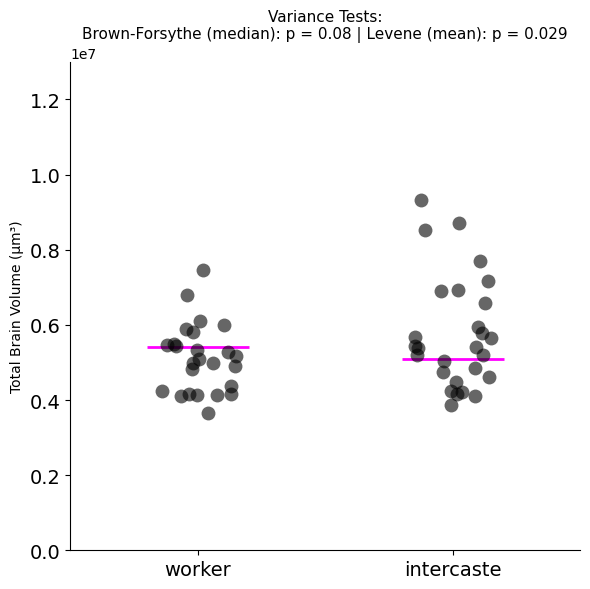

In [15]:
# Generating Supp Fig 2C -- worker vs intercaste

# Calculate medians
# Extract volumes and drop NaNs
intercaste_volumes = intercastevworker_df[
    intercastevworker_df['Condition'] == 'intercaste']['AMIRA volume'].dropna()

worker_volumes = intercastevworker_df[
    intercastevworker_df['Condition'] == 'worker']['AMIRA volume'].dropna()


# Run Brown-Forsythe test (median-centered)
bf_stat, bf_p = levene(intercaste_volumes, worker_volumes, center='median')

# Run Levene’s test (mean-centered)
lev_stat, lev_p = levene(intercaste_volumes, worker_volumes, center='mean')

# Mann-Whitney U test (tests for difference in medians/distributions)
mw_stat, mw_p = mannwhitneyu(intercaste_volumes, worker_volumes, alternative='two-sided')

plt.figure(figsize=(6, 6))

# Overlay individual data points (scatter plot)
sns.stripplot(x='Condition', y='AMIRA volume', data=intercastevworker_df, order=['worker', 'intercaste'], jitter=0.15, size=10, alpha=0.6, color='black')

# Set y-axis limits
plt.ylim(0, 1.3e7)

# Keep x-axis limits the same
plt.xlim(-0.5, 1.5)

# Change font sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Plot median lines
medians = intercastevworker_df.groupby('Condition')['AMIRA volume'].median()
plt.hlines(y=[medians], xmin=[-0.2, 0.8], xmax=[0.2, 1.2], colors='magenta', linewidth=2)

# Add axis labels
plt.ylabel("Total Brain Volume (μm³)")
plt.xlabel("")


# Annotate both p-values in the title
plt.title(
    f"Variance Tests:\n"
    f"Brown-Forsythe (median): p = {bf_p:.3g} | "
    f"Levene (mean): p = {lev_p:.3g}",
    fontsize=11
)

# Keep only x and y axis 
sns.despine(top=True, right=True)

# Tighten the layout to avoid any clipping
plt.tight_layout()

# Save the plot as an EPS and PNGfile
plt.savefig("figures/SF2C_worker_vs_intercaste.eps", format='eps', dpi=300)
plt.savefig("figures/SF2C_worker_vs_intercaste.png", format='png', dpi=600)

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


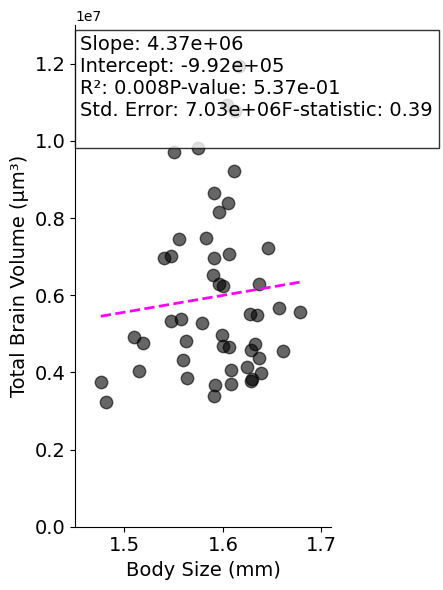

In [16]:
# Generating Supp Fig 2E -- brain volume vs body size

plt.figure(figsize=(4, 6))

# Scatter plot for continuous body length on the x-axis and total brain volume on the y-axis
plt.scatter(brainvbody_df['body length'], brainvbody_df['AMIRA volume'], alpha=0.6, color='black', s=80)

# Fit a linear regression line
slope, intercept, r_value, p_value, std_err = linregress(brainvbody_df['body length'], brainvbody_df['AMIRA volume'])

# Generate regression line
x_vals = np.linspace(brainvbody_df['body length'].min(), brainvbody_df['body length'].max(), 100)
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, color='magenta', linewidth=2, linestyle='--')

# Calculate F-statistic
n = len(brainvbody_df)
r_squared = r_value ** 2
f_statistic = (r_squared / (1 - r_squared)) * (n - 2)

# Regression statistics text (formatted nicely)
regression_text = (
    f"Slope: {slope:.2e}\n"
    f"Intercept: {intercept:.2e}\n"
    f"R²: {r_value**2:.3f}" #"\n"
    f"P-value: {p_value:.2e}\n"
    f"Std. Error: {std_err:.2e}"
    f"F-statistic: {f_statistic:.2f}\n"
)

# Add text to top-right corner of the plot
plt.text(
    0.02, 0.98, regression_text, transform=plt.gca().transAxes, 
    fontsize=14, verticalalignment='top', horizontalalignment='left',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='black')
)

# Set y-axis limits (total brain volume)
plt.ylim(0, 1.3e7)

plt.xlim(1.45, 1.71)
plt.xticks([1.5, 1.6, 1.7], fontsize=14)

# Labels and title
plt.xlabel("Body Size (mm)", fontsize=14)
plt.ylabel("Total Brain Volume (μm³)", fontsize=14)

# Change font sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Keep only x and y axis 
sns.despine(top=True, right=True)

# Adjust layout to avoid clipping of labels
plt.tight_layout()

# Save the plot as an EPS and PNGfile
plt.savefig("figures/SF2E_brainvbodylength.eps", format='eps', dpi=300)
plt.savefig("figures/SF2E_brainvbodylength.png", format='png', dpi=600)

plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


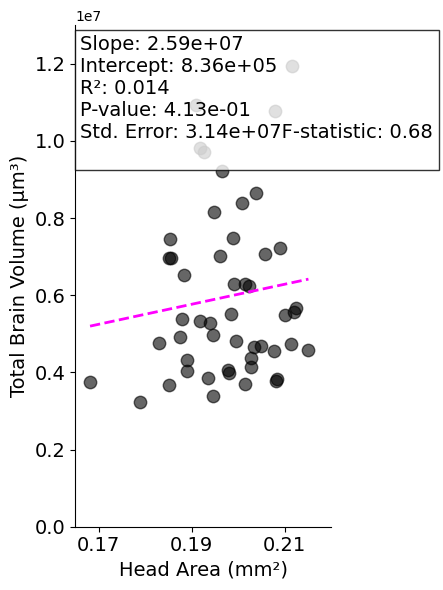

In [17]:
# Generating Supp Fig 2G -- brain volume vs head area

plt.figure(figsize=(4, 6))

# Scatter plot for continuous body length on the x-axis and total brain volume on the y-axis
plt.scatter(brainvbody_df['head area'], brainvbody_df['AMIRA volume'], alpha=0.6, color='black', s=80)

# Fit a linear regression line
slope, intercept, r_value, p_value, std_err = linregress(brainvbody_df['head area'], brainvbody_df['AMIRA volume'])

# Generate regression line
x_vals = np.linspace(brainvbody_df['head area'].min(), brainvbody_df['head area'].max(), 100)
y_vals = slope * x_vals + intercept
plt.plot(x_vals, y_vals, color='magenta', linewidth=2, linestyle='--')

# Calculate F-statistic
n = len(brainvbody_df)
r_squared = r_value ** 2
f_statistic = (r_squared / (1 - r_squared)) * (n - 2)

# Regression statistics text (formatted nicely)
regression_text = (
    f"Slope: {slope:.2e}\n"
    f"Intercept: {intercept:.2e}\n"
    f"R²: {r_value**2:.3f}\n"
    f"P-value: {p_value:.2e}\n"
    f"Std. Error: {std_err:.2e}"
    f"F-statistic: {f_statistic:.2f}\n"
)

# Add text to top-right corner of the plot
plt.text(
    0.02, 0.98, regression_text, transform=plt.gca().transAxes, 
    fontsize=14, verticalalignment='top', horizontalalignment='left',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='black')
)

# Set y-axis limits (total brain volume)
plt.ylim(0, 1.3e7)

# Keep x-axis limits the same (adjust for body length range if necessary)
plt.xlim(.165,.22)
plt.xticks([.17, .19, .21], fontsize=14)

# Labels and title
plt.xlabel("Head Area (mm²)", fontsize=14)
plt.ylabel("Total Brain Volume (μm³)", fontsize=14)

# Change font sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Keep only x and y axis 
sns.despine(top=True, right=True)

# Adjust layout to avoid clipping of labels
plt.tight_layout()

# Save the plot as an EPS and PNGfile
plt.savefig("figures/SF2F_brainvheadarea.eps", format='eps', dpi=300)
plt.savefig("figures/SF2F_brainvheadarea.png", format='png', dpi=600)

plt.show()